In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import *
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
import logging

mpl.rcParams['figure.dpi'] = 150
logging.disable(logging.CRITICAL)


### Loading and Joining Datasets

In [5]:
country_code = 'ES'
area = lookup_area(country_code)

df_countries = pd.read_csv('../countries.csv', index_col = 'country')

lat = df_countries.loc[country_code].latitude.astype('str')
lon = df_countries.loc[country_code].longitude.astype('str')

In [3]:
# Get weather data from Open Meteo API

url = 'https://api.open-meteo.com/v1/forecast?' + \
      'latitude=' + lat + \
      '&longitude=' + lon + \
      '&hourly=temperature_2m,relativehumidity_2m,precipitation,cloudcover,direct_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m,pressure_msl&past_days=31'

response = urlopen(url)
data_json = json.loads(response.read())

df_weather = pd.DataFrame(data_json['hourly'])
df_weather.set_index(pd.DatetimeIndex(pd.to_datetime(df_weather['time'])), inplace = True)
df_weather['cloud_ma'] = df_weather['cloudcover'].rolling(24, min_periods = 1, center = True).mean()
df_weather['pressure_msl'].fillna(method = 'bfill', inplace = True)
df_weather.head()

,precipitation,relativehumidity_2m,cloudcover,winddirection_10m,pressure_msl,direct_radiation,windgusts_10m,windspeed_10m,temperature_2m,time,direct_normal_irradiance,cloud_ma
time,,,,,,,,,,,,
2022-06-09 00:00:00,0.0,57.0,100.0,257.0,1015.6,0.0,5.0,3.3,20.6,2022-06-09T00:00,0.0,15.000000
2022-06-09 01:00:00,0.0,59.0,50.0,257.0,1015.6,0.0,6.8,3.3,20.0,2022-06-09T01:00,0.0,13.923077
2022-06-09 02:00:00,0.0,63.0,30.0,279.0,1015.6,0.0,6.1,2.2,19.4,2022-06-09T02:00,0.0,12.928571
2022-06-09 03:00:00,0.0,67.0,0.0,320.0,1015.6,0.0,5.4,2.8,18.5,2022-06-09T03:00,0.0,12.066667
2022-06-09 04:00:00,0.0,72.0,0.0,324.0,1015.6,0.0,6.1,3.1,17.6,2022-06-09T04:00,0.0,11.312500


In [6]:
# Get energy data from ENTSO-E API

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(months = 1)
%time df_energy = client.query_generation(area, start=start,end=end, nett = True, psr_type=None)
df_energy.set_index(df_energy.index.tz_convert(None), inplace = True)
df_energy = df_energy.resample('H').mean()


Wall time: 22 s


In [5]:
# Join energy and weather data

df_join = df_energy.join(df_weather, how = 'inner')

df_join.head()

,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Hydro Pumped Storage,...,cloudcover,winddirection_10m,pressure_msl,direct_radiation,windgusts_10m,windspeed_10m,temperature_2m,time,direct_normal_irradiance,cloud_ma
2022-06-10 01:00:00,512.0,0.0,0.0,7294.0,549.0,127.0,0.0,0.0,0.0,-572.0,...,0.0,50.0,1015.6,0.0,26.3,9.4,21.9,2022-06-10T01:00,0.0,5.375000
2022-06-10 02:00:00,508.0,0.0,0.0,7314.0,554.0,130.0,0.0,0.0,0.0,-572.0,...,0.0,55.0,1015.6,0.0,20.9,7.5,21.5,2022-06-10T02:00,0.0,5.541667
2022-06-10 03:00:00,531.0,0.0,0.0,7310.0,590.0,142.0,0.0,0.0,0.0,-309.0,...,0.0,60.0,1015.6,0.0,16.9,5.8,21.2,2022-06-10T03:00,0.0,5.916667
2022-06-10 04:00:00,532.0,0.0,0.0,7750.0,637.0,177.0,0.0,0.0,0.0,-26.0,...,0.0,35.0,1015.6,0.0,13.3,5.7,20.7,2022-06-10T04:00,0.0,10.083333
2022-06-10 05:00:00,508.0,0.0,0.0,8804.0,681.0,184.0,0.0,0.0,0.0,0.0,...,2.0,41.0,1015.6,0.0,12.6,3.8,20.2,2022-06-10T05:00,0.0,10.166667


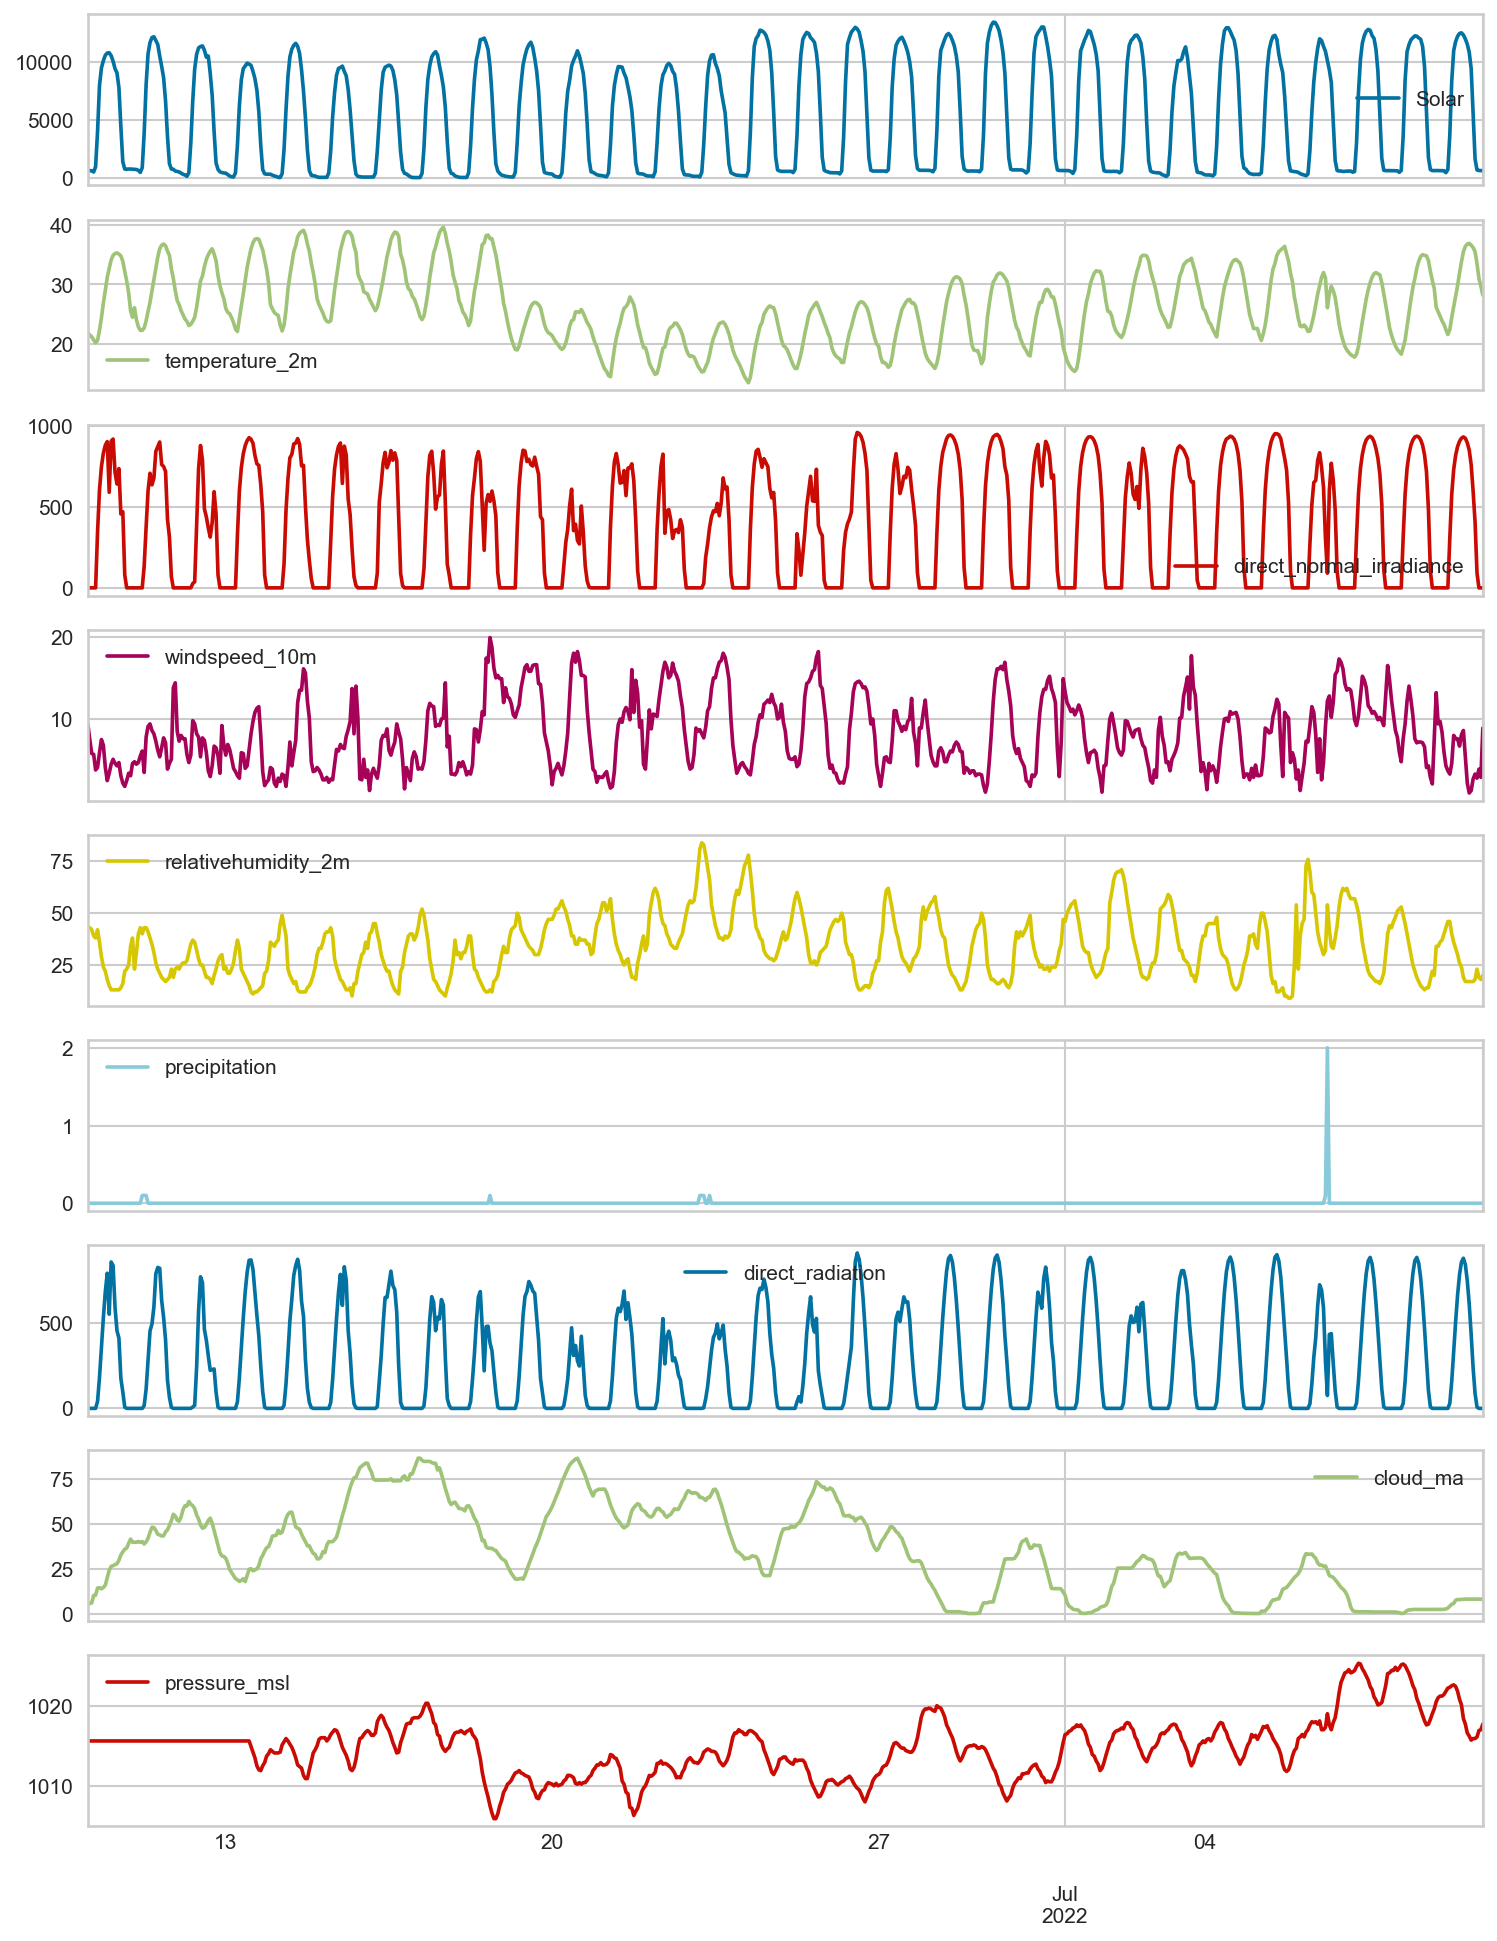

In [6]:
# Visualizing solar energy and related variables 

columns = ['Solar', 'temperature_2m', 'direct_normal_irradiance',
           'windspeed_10m', 'relativehumidity_2m', 'precipitation',
           'direct_radiation', 'cloud_ma', 'pressure_msl']

df_join[columns].plot(subplots = True, figsize = (12,16))
plt.show()

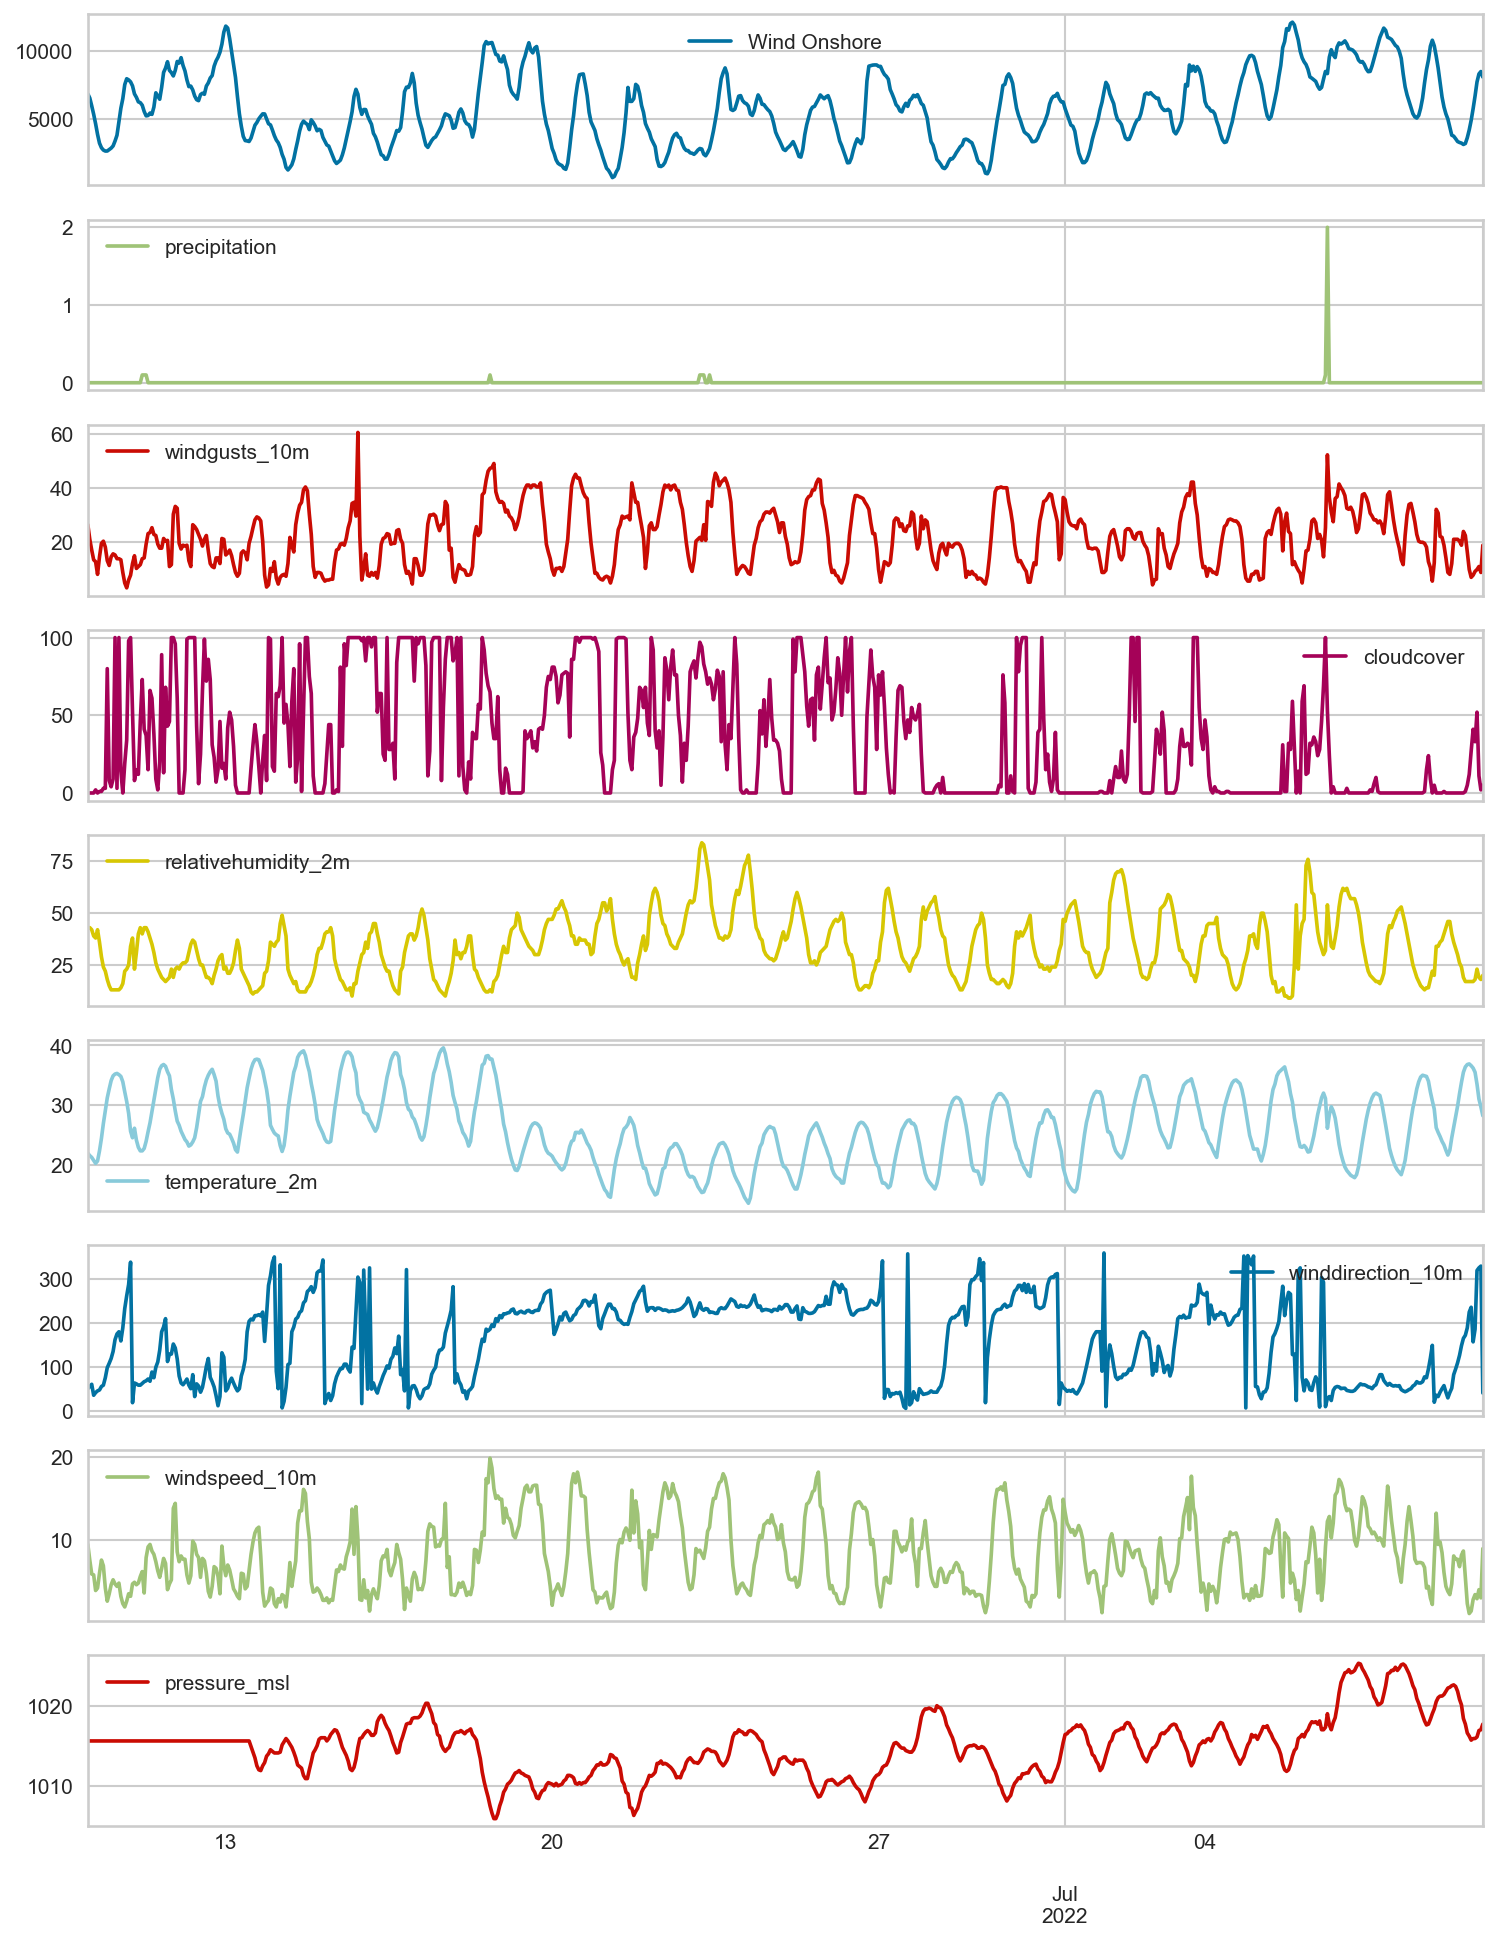

In [7]:
columns = ['Wind Onshore', 'precipitation', 'windgusts_10m', 'cloudcover', 'relativehumidity_2m',
           'temperature_2m', 'winddirection_10m', 'windspeed_10m', 'pressure_msl']

df_join[columns].plot(subplots = True, figsize = (12, 16))
plt.show()

### Forecasting with PyCaret

In [8]:
columns = ['Solar', 'direct_radiation']

ts = setup(data = df_join[columns], target = 'Solar',
           fh = 48, enforce_exogenous = False, fold = 3)
           

,Description,Value
0,session_id,7978
1,Target,Solar
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(719, 2)"
5,Transformed data shape,"(719, 2)"
6,Transformed train set shape,"(671, 2)"
7,Transformed test set shape,"(48, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [9]:
model = create_model('xgboost_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-07-01 23:00,1.4270,1.2773,690.9624,1012.3031,0.3798,0.2737,0.9549
1,2022-07-03 23:00,1.0280,0.9569,505.2975,765.2003,0.2447,0.3217,0.9774
2,2022-07-05 23:00,1.1901,1.0021,615.9028,838.2456,0.1923,0.2236,0.9717
Mean,NaT,1.2151,1.0788,604.0543,871.9163,0.2722,0.2730,0.9680
SD,NaT,0.1638,0.1416,76.2590,103.6508,0.0790,0.0401,0.0096


Processing:   0%|          | 0/4 [00:00<?, ?it/s]